In [30]:
import pandas as pd
import numpy as np 

TEST_SIZE = 0.2
data = pd.DataFrame(pd.read_csv("heart_2022_no_nans.csv"))

In [31]:
data = data.drop(columns=["State", "RaceEthnicityCategory"])
data = data.replace("Female", "0")
data = data.replace("Male", "1")
data["AgeCategory"] = data["AgeCategory"].str[4:6]

data["GeneralHealth"] = data["GeneralHealth"].replace({"Poor":"0", "Fair":"1", "Good":"2", "Very good":"3", "Excellent":"4"})
data["LastCheckupTime"] = data["LastCheckupTime"].replace({"Within past year (anytime less than 12 months ago)":"0",
                                                           "Within past 2 years (1 year but less than 2 years ago)": "1",
                                                          "Within past 5 years (2 years but less than 5 years ago)": "2",
                                                          "5 or more years ago": "3"})

data["RemovedTeeth"] = data["RemovedTeeth"].replace({"All": "3", 
                                                     "6 or more, but not all": "2",
                                                     "1 to 5": "1",
                                                     "None of them": "0"
                                                    })


data["HadDiabetes"] = data["HadDiabetes"].replace({"No":"0",
                                                  "No, pre-diabetes or borderline diabetes": "1",
                                                  "Yes, but only during pregnancy (female)": "2",
                                                  "Yes": "3"})

data["SmokerStatus"] = data["SmokerStatus"].replace({"Never smoked": "0",
                                                    "Former smoker": "1",
                                                    "Current smoker - now smokes some days": "2",
                                                    "Current smoker - now smokes every day": "3"})

data["ECigaretteUsage"] = data["ECigaretteUsage"].replace({"Never used e-cigarettes in my entire life": "0",
                                                          "Not at all (right now)": "1",
                                                          "Use them some days": "2",
                                                          "Use them every day":"3"})

data["TetanusLast10Tdap"] = data["TetanusLast10Tdap"].replace({"No, did not receive any tetanus shot in the past 10 years": "0",
                                                              "Yes, received tetanus shot but not sure what type": "1",
                                                              "Yes, received tetanus shot, but not Tdap": "2",
                                                              "Yes, received Tdap": "3"})
data["CovidPos"] = data["CovidPos"].replace({"No": "0", 
                                             "Tested positive using home test without a health professional": "1",
                                             "Yes": "2"})

data = data.replace({"No": "0",
                     "Yes": "1"})

data.head()

,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,HadAngina,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,0,3,4.0,0.0,0,1,9.0,0,0,0,...,1.60,71.67,27.99,0,0,1,1,3,0,0
1,1,3,0.0,0.0,0,1,6.0,0,0,0,...,1.78,95.25,30.13,0,0,1,1,1,0,0
2,1,3,0.0,0.0,0,0,8.0,2,0,0,...,1.85,108.86,31.66,1,0,0,1,0,0,2
3,0,1,5.0,0.0,0,1,9.0,0,0,0,...,1.70,90.72,31.32,0,0,1,1,0,0,2
4,0,2,3.0,15.0,0,1,5.0,1,0,0,...,1.55,79.38,33.07,0,0,1,1,0,0,0


## Підготовка до тренування моделей

In [32]:
from sklearn.model_selection import  cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

le = LabelEncoder()
data1 = data.copy(deep = True)


col = list(data.columns)
categorical_features = []
numerical_features = []
for i in data1.columns:
    if len(data[i].unique()) > 6:
        numerical_features.append(i)
    else:
        data1[i] = le.fit_transform(data1[i])
        categorical_features.append(i)

In [33]:
X = data1.drop(['HadHeartAttack'], axis=1)
y = data1['HadHeartAttack']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_initial_train, X_initial_test, y_initial_train, y_initial_test = train_test_split(X_scaled, y, test_size=TEST_SIZE, random_state=0)

Одразу масштабуємо та розділяємо дані на набори для тренування та тестування. Балансування класів на всій множині даних призводить до витоку даних та перенавчанню моделі (особливо дерева рішень), також це завадить корректні оцінці моделі на початкових даних. Балансування класів буде відбуватись на тренувальному наборі, тестування моделей - на наборі для тестування.

### Функція валідації моделі

Модель випробовується на початкових даних. Працює як для моделі логістичної регресії, так і для моделі дерева рішень.

In [34]:
all_logreg_logs = pd.DataFrame()
all_dtree_logs = pd.DataFrame()

def validate_model(model, balancing_method_name: str):        
    global all_logreg_logs, all_dtree_logs, X_initial_test, y_initial_test
    
    if isinstance(model, LogisticRegression):
        weights = model.coef_[0]
        intercept = model.intercept_[0]
        
        logits = np.dot(X_initial_test, weights) + intercept
        probabilities = 1 / (1 + np.exp(-logits))
        y_pred_initial = (probabilities >= 0.5).astype(int)
    else:
        probabilities = model.predict_proba(X_initial_test)[:, 1]
        y_pred_initial = model.predict(X_initial_test)
    
    accuracy_initial = accuracy_score(y_initial_test, y_pred_initial)
    precision_initial = precision_score(y_initial_test, y_pred_initial)
    recall_initial = recall_score(y_initial_test, y_pred_initial)
    f1_initial = f1_score(y_initial_test, y_pred_initial)
    roc_auc_initial = roc_auc_score(y_initial_test, probabilities)
    initial_validation_log = pd.DataFrame(data=[accuracy_initial,
                                                precision_initial,
                                                recall_initial,
                                                f1_initial,
                                                roc_auc_initial],
                                          index=['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC'],
                                          columns=[f"{balancing_method_name}"])
    
    if isinstance(model, LogisticRegression):
        all_logreg_logs = pd.concat([all_logreg_logs, initial_validation_log], axis=1)
        print("\nLogistic Regression")
        print(all_logreg_logs.transpose())
    else:
        all_dtree_logs = pd.concat([all_dtree_logs, initial_validation_log], axis=1)
        print("\nOther models")
        print(all_dtree_logs.transpose())

### Функції тренування моделей

Відбувається почергове тренування спочатку моделі логістичної регресії, а після й моделі дерева рішень. Після ввідбувається валідація кожної моделі та заноситься у загальний лог по всім методам та моделям.

In [35]:
def train_models(X_train_balanced, y_train_balanced, balancing_method_name: str):
    
    logreg_model = train_regression_model(X_train_balanced, y_train_balanced)
    dtree_model = train_dtree_model(X_train_balanced, y_train_balanced)

    print("\n\nComparison After Validation")
    validate_model(logreg_model, balancing_method_name)
    validate_model(dtree_model, "Dtree " + balancing_method_name)

In [36]:
def train_regression_model(X_train_balanced, y_train_balanced):
    logreg = LogisticRegression(solver="liblinear", penalty="l2", C=0.00001, max_iter=10000)
    logreg.fit(X_train_balanced, y_train_balanced)
    
    return logreg

In [37]:
def train_dtree_model(X_train_balanced, y_train_balanced):
    dtree = DecisionTreeClassifier(random_state=0)
    dtree.fit(X_train_balanced, y_train_balanced)

    return dtree

In [38]:
def show_stats(y_balanced, balanced_method_name):
    plt.figure(figsize=(10, 5))
    ax = sns.countplot(x=y_balanced, hue=y_balanced, palette="Set2")
    for container in ax.containers:
        ax.bar_label(container, label_type='center', rotation=0, color='white')
    plt.title(f"Розподіл після {balanced_method_name}", size=16)
    plt.show()

## Тренування моделей

Усього було випробовано 8 різних комбінованих методів балансування класів, які здебільшого обирались як комбінація кращих методів з порівнянь методів oversampling та undersampling у відповідних блокнотах. 

Перелік обраних комбінованих методів:

SMOTE + TomekLinks, SMOTE + ENN, Balanced Random Forest, Easy Ensemble,XgBoost, Random Oversampling + Tomek Links, Random Oversampling + One Sided Selection, ADASYN + Tomek Links, ADASYN + One Sided Selection.

### Without sampling

Перевірка точності моделі без балансування класів. Так ми зможемо зрозуміти якщо модель після балансування класів буде менш точною.

In [39]:
train_models(X_initial_train, y_initial_train, "Without_Sampling")



Comparison After Validation

Logistic Regression
                  Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling  0.946957   0.538106  0.339898  0.416629  0.889924

Other models
                        Accuracy  Precision    Recall  F1-score       AUC
Dtree Without_Sampling   0.91259   0.257694  0.302334  0.278235  0.625469


### SMOTE + Tomek Links

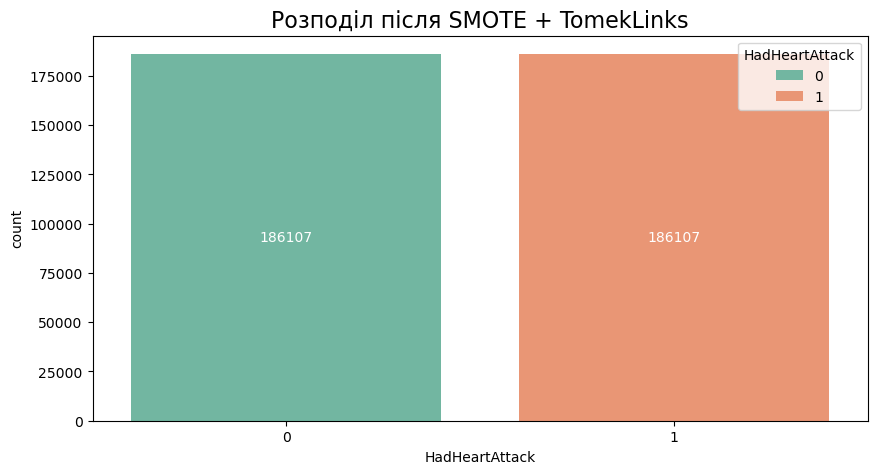

In [40]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek()
X_SMT, y_SMT = smt.fit_resample(X_initial_train, y_initial_train)

show_stats(y_SMT, "SMOTE + TomekLinks")

In [41]:
train_models(X_SMT, y_SMT, "SMOTE_TomekLinks")



Comparison After Validation

Logistic Regression
                  Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling  0.946957   0.538106  0.339898  0.416629  0.889924
SMOTE_TomekLinks  0.749212   0.164593  0.858862  0.276246  0.891889

Other models
                        Accuracy  Precision    Recall  F1-score       AUC
Dtree Without_Sampling   0.91259   0.257694  0.302334  0.278235  0.625469
Dtree SMOTE_TomekLinks   0.91320   0.266565  0.318381  0.290178  0.633342


### SMOTE + ENN

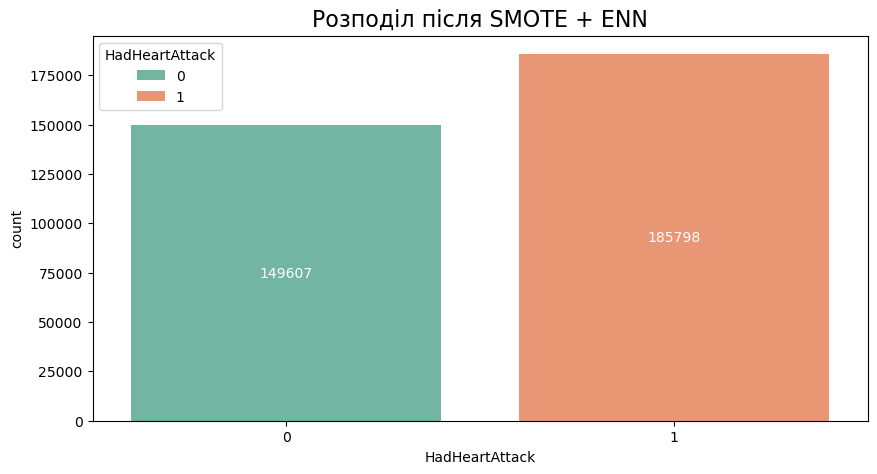

In [42]:
from imblearn.combine import SMOTEENN

sme = SMOTEENN()
X_SME, y_SME = sme.fit_resample(X_initial_train, y_initial_train)

show_stats(y_SME, "SMOTE + ENN")

In [43]:
train_models(X_SME, y_SME, "SMOTE_ENN")



Comparison After Validation

Logistic Regression
                  Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling  0.946957   0.538106  0.339898  0.416629  0.889924
SMOTE_TomekLinks  0.749212   0.164593  0.858862  0.276246  0.891889
SMOTE_ENN         0.693527   0.142667  0.898249  0.246226  0.888628

Other models
                        Accuracy  Precision    Recall  F1-score       AUC
Dtree Without_Sampling  0.912590   0.257694  0.302334  0.278235  0.625469
Dtree SMOTE_TomekLinks  0.913200   0.266565  0.318381  0.290178  0.633342
Dtree SMOTE_ENN         0.894929   0.282437  0.574763  0.378755  0.744293


### Balanced Random Forest 

In [44]:
from imblearn.ensemble import BalancedRandomForestClassifier

brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42, sampling_strategy='all', replacement=True, bootstrap=False)
brf.fit(X_initial_train, y_initial_train)

validate_model(brf, "Balanced Random Forest")


Other models
                        Accuracy  Precision    Recall  F1-score       AUC
Dtree Without_Sampling  0.912590   0.257694  0.302334  0.278235  0.625469
Dtree SMOTE_TomekLinks  0.913200   0.266565  0.318381  0.290178  0.633342
Dtree SMOTE_ENN         0.894929   0.282437  0.574763  0.378755  0.744293
Balanced Random Forest  0.880276   0.275552  0.704960  0.396228  0.892777


### EasyEnsemble

In [45]:
from imblearn.ensemble import EasyEnsembleClassifier

eec = EasyEnsembleClassifier(n_estimators=100, random_state=42)
eec.fit(X_initial_train, y_initial_train)

validate_model(eec, "Easy_Ensemble")


Other models
                        Accuracy  Precision    Recall  F1-score       AUC
Dtree Without_Sampling  0.912590   0.257694  0.302334  0.278235  0.625469
Dtree SMOTE_TomekLinks  0.913200   0.266565  0.318381  0.290178  0.633342
Dtree SMOTE_ENN         0.894929   0.282437  0.574763  0.378755  0.744293
Balanced Random Forest  0.880276   0.275552  0.704960  0.396228  0.892777
Easy_Ensemble           0.826176   0.213377  0.788840  0.335896  0.892188


### Without sampling XgBoost

In [46]:
import xgboost as xgb

scale_pos_weight = len(y_initial_train[y_initial_train == 0]) / len(y_initial_train[y_initial_train == 1])

# Стандартні параметри
params = {
    'objective': 'binary:logistic',
    'scale_pos_weight': scale_pos_weight,
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 100
}

xgb_model = xgb.XGBClassifier(**params)
xgb_model.fit(X_initial_train, y_initial_train)

validate_model(xgb_model, "Xgboost")


Other models
                        Accuracy  Precision    Recall  F1-score       AUC
Dtree Without_Sampling  0.912590   0.257694  0.302334  0.278235  0.625469
Dtree SMOTE_TomekLinks  0.913200   0.266565  0.318381  0.290178  0.633342
Dtree SMOTE_ENN         0.894929   0.282437  0.574763  0.378755  0.744293
Balanced Random Forest  0.880276   0.275552  0.704960  0.396228  0.892777
Easy_Ensemble           0.826176   0.213377  0.788840  0.335896  0.892188
Xgboost                 0.823920   0.213081  0.801969  0.336702  0.896584


### Random Oversampling + Tomek Links

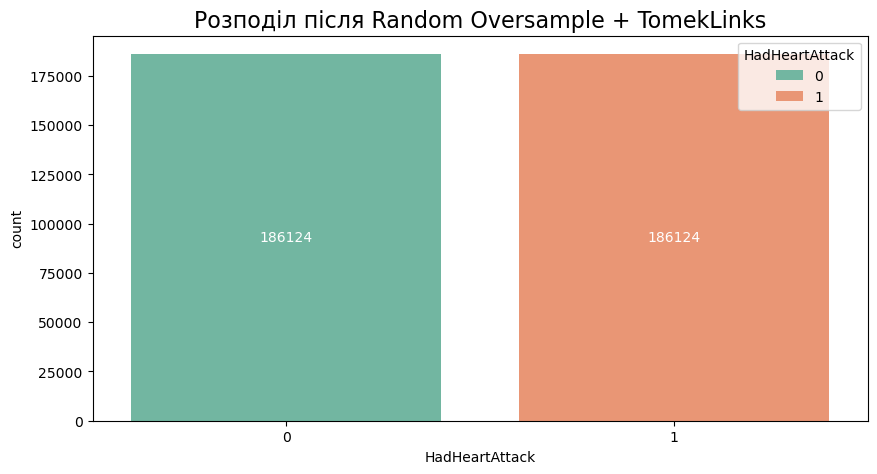

In [47]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks

oversample = RandomOverSampler(sampling_strategy='minority')

X_ROS, y_ROS = oversample.fit_resample(X_initial_train, y_initial_train)

tomek = TomekLinks()
X_RTL, y_RTL = tomek.fit_resample(X_ROS, y_ROS)

show_stats(y_RTL, "Random Oversample + TomekLinks")

In [48]:
train_models(X_RTL, y_RTL, "Rand_Oversampl+TL")



Comparison After Validation

Logistic Regression
                   Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling   0.946957   0.538106  0.339898  0.416629  0.889924
SMOTE_TomekLinks   0.749212   0.164593  0.858862  0.276246  0.891889
SMOTE_ENN          0.693527   0.142667  0.898249  0.246226  0.888628
Rand_Oversampl+TL  0.755757   0.167908  0.855215  0.280704  0.891928

Other models
                         Accuracy  Precision    Recall  F1-score       AUC
Dtree Without_Sampling   0.912590   0.257694  0.302334  0.278235  0.625469
Dtree SMOTE_TomekLinks   0.913200   0.266565  0.318381  0.290178  0.633342
Dtree SMOTE_ENN          0.894929   0.282437  0.574763  0.378755  0.744293
Balanced Random Forest   0.880276   0.275552  0.704960  0.396228  0.892777
Easy_Ensemble            0.826176   0.213377  0.788840  0.335896  0.892188
Xgboost                  0.823920   0.213081  0.801969  0.336702  0.896584
Dtree Rand_Oversampl+TL  0.919480   0.264842  0.250547  0.257496 

### Random Oversampling + One Sided Selection

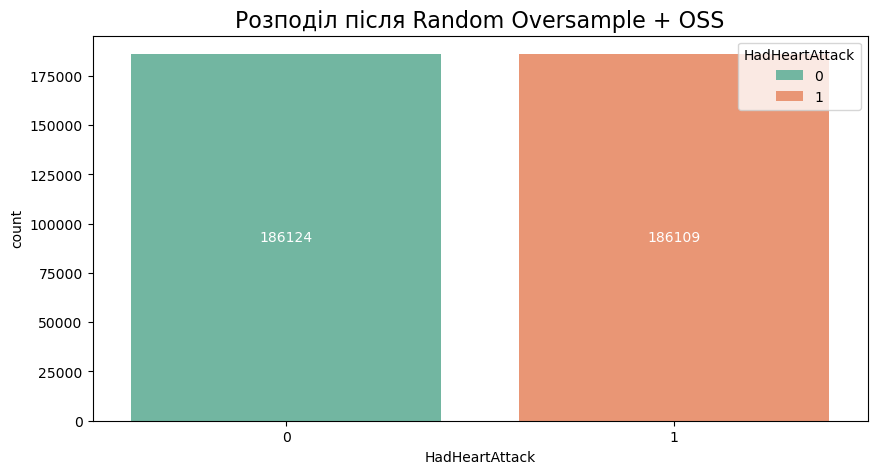

In [49]:
from imblearn.under_sampling import OneSidedSelection

oss = OneSidedSelection()
X_ROSS, y_ROSS = oss.fit_resample(X_ROS, y_ROS)
show_stats(y_ROSS, "Random Oversample + OSS")

In [50]:
train_models(X_ROSS, y_ROSS, "Rand_Oversampl+OSS")



Comparison After Validation

Logistic Regression
                    Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling    0.946957   0.538106  0.339898  0.416629  0.889924
SMOTE_TomekLinks    0.749212   0.164593  0.858862  0.276246  0.891889
SMOTE_ENN           0.693527   0.142667  0.898249  0.246226  0.888628
Rand_Oversampl+TL   0.755757   0.167908  0.855215  0.280704  0.891928
Rand_Oversampl+OSS  0.755878   0.167980  0.855215  0.280805  0.891931

Other models
                          Accuracy  Precision    Recall  F1-score       AUC
Dtree Without_Sampling    0.912590   0.257694  0.302334  0.278235  0.625469
Dtree SMOTE_TomekLinks    0.913200   0.266565  0.318381  0.290178  0.633342
Dtree SMOTE_ENN           0.894929   0.282437  0.574763  0.378755  0.744293
Balanced Random Forest    0.880276   0.275552  0.704960  0.396228  0.892777
Easy_Ensemble             0.826176   0.213377  0.788840  0.335896  0.892188
Xgboost                   0.823920   0.213081  0.801969  0.

### ADASYN + Tomek Links

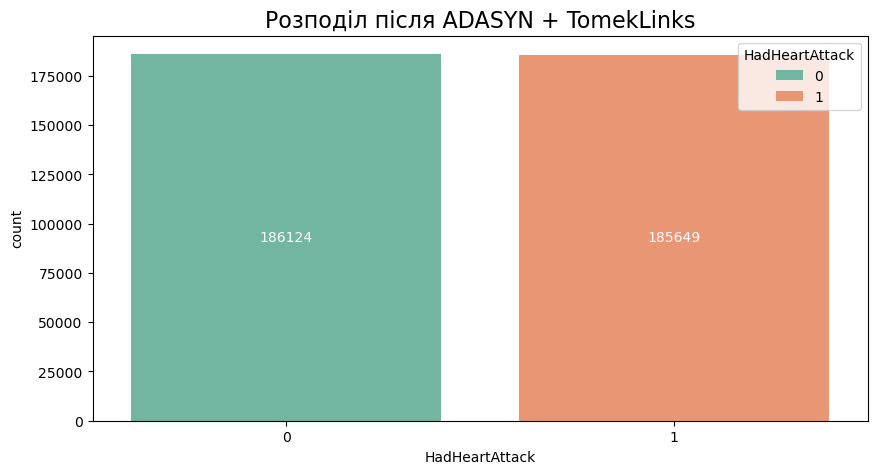

In [51]:
from imblearn.over_sampling import ADASYN 
from sklearn.neighbors import NearestNeighbors

adasyn = ADASYN(n_neighbors=NearestNeighbors(n_jobs=-1), random_state=0)
X_adasyn, y_adasyn = adasyn.fit_resample(X_initial_train, y_initial_train)

tomek = TomekLinks()
X_ATL, y_ATL = tomek.fit_resample(X_adasyn, y_adasyn)

show_stats(y_adasyn, "ADASYN + TomekLinks")

In [52]:
train_models(X_ATL, y_ATL, "ADASYN_TomekLinks")



Comparison After Validation

Logistic Regression
                    Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling    0.946957   0.538106  0.339898  0.416629  0.889924
SMOTE_TomekLinks    0.749212   0.164593  0.858862  0.276246  0.891889
SMOTE_ENN           0.693527   0.142667  0.898249  0.246226  0.888628
Rand_Oversampl+TL   0.755757   0.167908  0.855215  0.280704  0.891928
Rand_Oversampl+OSS  0.755878   0.167980  0.855215  0.280805  0.891931
ADASYN_TomekLinks   0.720943   0.153366  0.886579  0.261496  0.890254

Other models
                          Accuracy  Precision    Recall  F1-score       AUC
Dtree Without_Sampling    0.912590   0.257694  0.302334  0.278235  0.625469
Dtree SMOTE_TomekLinks    0.913200   0.266565  0.318381  0.290178  0.633342
Dtree SMOTE_ENN           0.894929   0.282437  0.574763  0.378755  0.744293
Balanced Random Forest    0.880276   0.275552  0.704960  0.396228  0.892777
Easy_Ensemble             0.826176   0.213377  0.788840  0.335896

### ADASYN + One Sided Selection

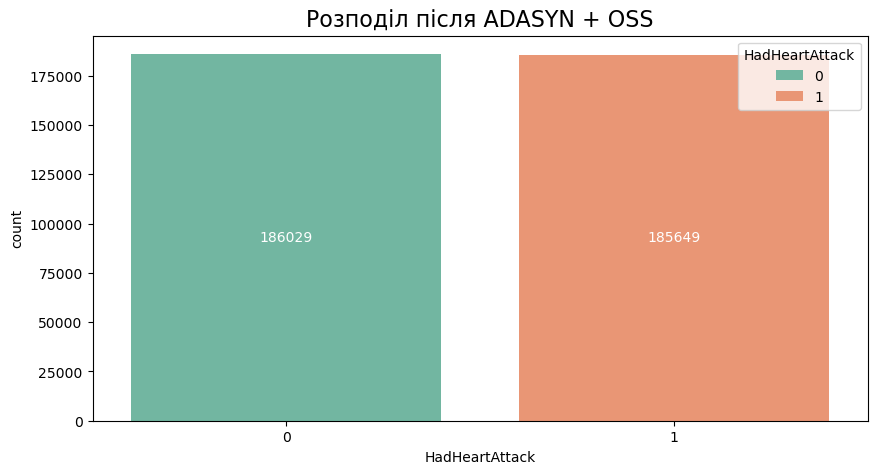

In [53]:
oss = OneSidedSelection()
X_AOSS, y_AOSS = oss.fit_resample(X_adasyn, y_adasyn)

show_stats(y_AOSS, "ADASYN + OSS")

In [54]:
train_models(X_AOSS, y_AOSS, "ADASYN_OSS")



Comparison After Validation

Logistic Regression
                    Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling    0.946957   0.538106  0.339898  0.416629  0.889924
SMOTE_TomekLinks    0.749212   0.164593  0.858862  0.276246  0.891889
SMOTE_ENN           0.693527   0.142667  0.898249  0.246226  0.888628
Rand_Oversampl+TL   0.755757   0.167908  0.855215  0.280704  0.891928
Rand_Oversampl+OSS  0.755878   0.167980  0.855215  0.280805  0.891931
ADASYN_TomekLinks   0.720943   0.153366  0.886579  0.261496  0.890254
ADASYN_OSS          0.720882   0.153293  0.886214  0.261375  0.890251

Other models
                          Accuracy  Precision    Recall  F1-score       AUC
Dtree Without_Sampling    0.912590   0.257694  0.302334  0.278235  0.625469
Dtree SMOTE_TomekLinks    0.913200   0.266565  0.318381  0.290178  0.633342
Dtree SMOTE_ENN           0.894929   0.282437  0.574763  0.378755  0.744293
Balanced Random Forest    0.880276   0.275552  0.704960  0.396228  0.89

## Висновки

З отриманих результатів я можу зробити 3 головних висновки:
1. Для логістчиної регресії в даному випадку ми не можемо суттєво збільшити точність незалежно від методу балансування. Вдалось підвищити AUC на 0.3 пункти та вдвічі підвищити Recall за рахунок суттєвого зниження Precision. Це вказує на те, що модель стабільно передбачає близько 85-90% реальних серцевих нападів. Але серед усіх передбачень серцевих нападів багато похибок, близько 85%.
2. Дерева рішень краще за логістичну регресію лише при використанні 3 методів балансування: **Balanced Random Forest, Easy Ensemble та XgBoost**. І за допомогою цих методів балансування дерева рішень навіть обходять за точністю логістичну регресію в AUC на 1 пункт та середньому на 5 пунктів в Precision. Хоча так чи інакше ці варіанти мають досить низький Precision, що вказує на велику кількість помилкових передбачень серцевих нападів.
3. Після балансування класів сильно впав показник Precision та сильно виріс показник Recall. Можна сказати що моделі дуже добре справляються з передбаченням реальних випадків серцевих нападів, якщо існує ризик серцевого нападу - моделі скоріш за все його передбачать. Але якщо ціллю є висока точність усіх передбачень - усі моделі мають досить низьку точність.

З усіх випробуваних методів можна виділити Random Oversample + One Sided Selection за збалансоване підвищення усіх показник точності за рахунок зменшення Accuracy та Precision.

In [56]:
with pd.ExcelWriter('combined_comparison.xlsx') as writer:
    all_logreg_logs.transpose().to_excel(writer, sheet_name='LogisticRegression', index=False)
    all_dtree_logs.transpose().to_excel(writer, sheet_name='DecisionTree', index=False)

print("Excel файл успішно створено")

Excel файл успішно створено
